#### Concept — What Is Alpha Dispersion?

When your model outputs predicted_return for hundreds of stocks each month, you want to know:

* Are those predictions truly different across stocks?

* Or are they all clustered around the same value (weak signal)?

The cross-sectional dispersion (standard deviation) of predicted returns per month tells you that.

A higher dispersion means your model is confidently distinguishing good vs bad opportunities.
A lower dispersion means your alpha is flat → the optimizer can’t find meaningful weights.

In [1]:
# Cell 1: Imports and Setup

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import os

# Paths
PROJECT_ROOT = Path(r"D:\Portfolio Optimzation project")
ARTIFACTS_DIR = PROJECT_ROOT / "artifacts"
RESULTS_DIR = PROJECT_ROOT / "results" / "diagnostics"
os.makedirs(RESULTS_DIR, exist_ok=True)

# Files
ALPHA_FILE = ARTIFACTS_DIR / "alpha_predictions.csv"

# Parameters
ROLL_WINDOW = 6  # months


In [2]:
# Cell 2: Load alpha predictions and compute monthly dispersion

alpha_df = pd.read_csv(ALPHA_FILE, parse_dates=["date"])
alpha_df["date"] = pd.to_datetime(alpha_df["date"]).dt.tz_localize(None)
alpha_df = alpha_df.dropna(subset=["predicted_return"])

# Compute cross-sectional stats per month
disp_stats = (
    alpha_df.groupby("date")["predicted_return"]
    .agg(["mean", "std", "min", "max"])
    .rename(columns={"std": "dispersion"})
    .reset_index()
)

# Rolling metrics
disp_stats["rolling_disp"] = disp_stats["dispersion"].rolling(ROLL_WINDOW).mean()
disp_stats["rolling_mean"] = disp_stats["mean"].rolling(ROLL_WINDOW).mean()

print("Dispersion summary:")
print(disp_stats.describe().T)

disp_stats.to_csv(RESULTS_DIR / "alpha_dispersion.csv", index=False)


Dispersion summary:
              count                           mean                  min  \
date            106  2021-01-13 16:04:31.698113280  2016-08-31 00:00:00   
mean          106.0                       0.022298            -0.033388   
dispersion    106.0                       0.009371                  0.0   
min           106.0                       0.001911            -0.179194   
max           106.0                         0.1183            -0.012529   
rolling_disp  101.0                       0.009605                  0.0   
rolling_mean  101.0                       0.022699            -0.012531   

                              25%                  50%                  75%  \
date          2018-11-07 12:00:00  2021-01-14 12:00:00  2023-03-23 06:00:00   
mean                     0.007914             0.020775              0.03538   
dispersion               0.000111             0.003569             0.006649   
min                      0.000076             0.014124         

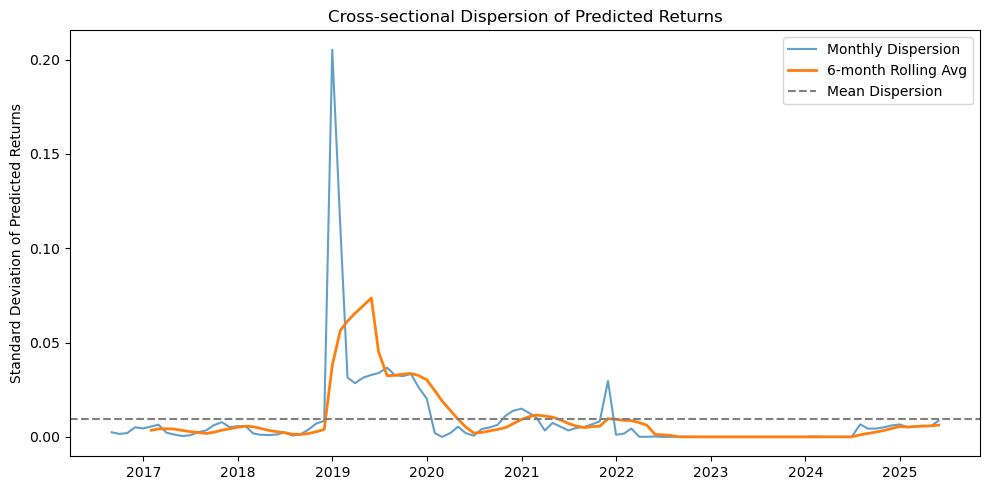

In [3]:
# Cell 3: Plot dispersion through time

plt.figure(figsize=(10,5))
plt.plot(disp_stats["date"], disp_stats["dispersion"], label="Monthly Dispersion", color="tab:blue", alpha=0.7)
plt.plot(disp_stats["date"], disp_stats["rolling_disp"], label=f"{ROLL_WINDOW}-month Rolling Avg", color="tab:orange", linewidth=2)
plt.title("Cross-sectional Dispersion of Predicted Returns")
plt.ylabel("Standard Deviation of Predicted Returns")
plt.axhline(disp_stats["dispersion"].mean(), color="gray", linestyle="--", label="Mean Dispersion")
plt.legend()
plt.tight_layout()
plt.savefig(RESULTS_DIR / "alpha_dispersion_timeseries.png", dpi=200)
plt.show()


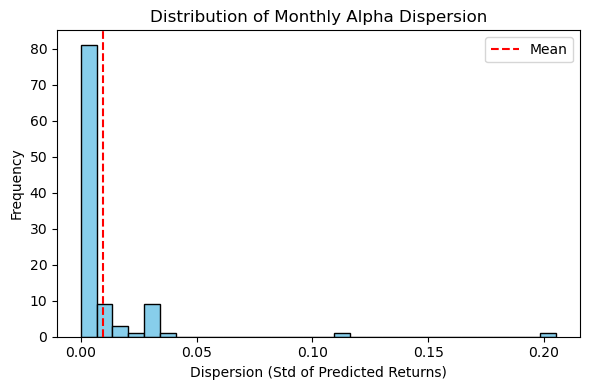

In [4]:
# Cell 4: Histogram of dispersion values

plt.figure(figsize=(6,4))
plt.hist(disp_stats["dispersion"].dropna(), bins=30, color="skyblue", edgecolor="black")
plt.title("Distribution of Monthly Alpha Dispersion")
plt.xlabel("Dispersion (Std of Predicted Returns)")
plt.ylabel("Frequency")
plt.axvline(disp_stats["dispersion"].mean(), color="red", linestyle="--", label="Mean")
plt.legend()
plt.tight_layout()
plt.savefig(RESULTS_DIR / "alpha_dispersion_histogram.png", dpi=200)
plt.show()


In [5]:
# Cell 5: Print interpretation-style summary

avg_disp = disp_stats["dispersion"].mean()
low_disp_months = (disp_stats["dispersion"] < 0.5 * avg_disp).sum()
high_disp_months = (disp_stats["dispersion"] > 1.5 * avg_disp).sum()

print("=== Alpha Dispersion Summary ===")
print(f"Average cross-sectional dispersion: {avg_disp:.4f}")
print(f"Low-dispersion months (flat signal): {low_disp_months}")
print(f"High-dispersion months (strong signal): {high_disp_months}")

if avg_disp < 0.005:
    print("⚠️ Your alphas are nearly flat — model isn't distinguishing stocks well.")
elif avg_disp < 0.02:
    print("⚠️ Weak alpha separation — consider stronger feature engineering.")
elif avg_disp < 0.05:
    print("✅ Moderate alpha dispersion — optimizer has some differentiation.")
else:
    print("🔥 Strong alpha dispersion — model confidently ranks stocks.")


=== Alpha Dispersion Summary ===
Average cross-sectional dispersion: 0.0094
Low-dispersion months (flat signal): 59
High-dispersion months (strong signal): 15
⚠️ Weak alpha separation — consider stronger feature engineering.
